In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Objective functions
# -------------------------------
def test_problem1(x):
    # Accepts x as a list or tuple [x1, x2]
    x1, x2 = x
    return 100 * (x1**2 - x2)**2 + (1 - x1) ** 2

def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Helper function for bounds
def get_bounds(problem, n_var):
    if problem == "test1":
        return [(-2.048, 2.048)] * n_var
    elif problem == "rastrigin":
        return [(-5.12, 5.12)] * n_var
    else:
        raise ValueError("Unknown problem")

# -------------------------------
# Encoding helpers
# -------------------------------
def decode_binary(bits, bounds, precision=4):
    # Decode bitstring to float with given bounds
    l, u = bounds
    intval = int("".join(str(b) for b in bits), 2)
    max_int = 2**len(bits) - 1
    return l + (u - l) * intval / max_int

def encode_binary(x, bounds, n_bits):
    l, u = bounds
    intval = int(round((x - l) / (u - l) * (2**n_bits - 1)))
    return list(bin(intval)[2:].zfill(n_bits))

# -------------------------------
# Selection
# -------------------------------
def roulette_wheel_selection(fitness):
    max_val = sum(fitness)
    pick = random.uniform(0, max_val)
    current = 0
    for i, f in enumerate(fitness):
        current += f
        if current > pick:
            return i

def tournament_selection(pop, fitness):
    i, j = random.sample(range(len(pop)), 2)
    return i if fitness[i] < fitness[j] else j

# -------------------------------
# Crossover
# -------------------------------
def single_point_crossover(p1, p2):
    if len(p1) <= 1:
        return p1[:], p2[:]
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

def simulated_binary_crossover(x1, x2, eta=20):
    if random.random() > 0.9:
        return x1, x2
    c1, c2 = [], []
    for i in range(len(x1)):
        u = random.random()
        if u <= 0.5:
            beta = (2 * u) ** (1.0 / (eta + 1))
        else:
            beta = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (eta + 1))
        c1.append(0.5 * ((1 + beta) * x1[i] + (1 - beta) * x2[i]))
        c2.append(0.5 * ((1 - beta) * x1[i] + (1 + beta) * x2[i]))
    return c1, c2

# -------------------------------
# Mutation
# -------------------------------
def binary_mutation(bitstring, pm):
    return [str(1-int(b)) if random.random() < pm else b for b in bitstring]

def polynomial_mutation(x, bounds, eta=20, pm=None):
    y = []
    n = len(x)
    if pm is None:
        pm = 1.0 / n
    for i in range(n):
        if random.random() < pm:
            l, u = bounds[i]
            delta1 = (x[i] - l) / (u - l)
            delta2 = (u - x[i]) / (u - l)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.)
            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1))
                deltaq = val**mut_pow - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1))
                deltaq = 1.0 - val**mut_pow
            xi = x[i] + deltaq * (u - l)
            xi = min(max(xi, l), u)
            y.append(xi)
        else:
            y.append(x[i])
    return y

# -------------------------------
# Genetic Algorithm
# -------------------------------
def genetic_algorithm(
    func, bounds, n_var, encoding="real", n_bits=16, pop_size=50, generations=100,
    mutation_rate=None, crossover_rate=0.9, selection="default"
):
    if mutation_rate is None:
        mutation_rate = 1.0 / (n_bits * n_var) if encoding == "binary" else 1.0 / n_var

    # Initialize population
    if encoding == "binary":
        chrom_length = n_bits * n_var
        population = [[str(random.randint(0,1)) for _ in range(chrom_length)] for _ in range(pop_size)]
    else:
        population = [np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds]).tolist() for _ in range(pop_size)]

    best_per_gen = []

    for gen in range(generations):
        # Decode & fitness
        if encoding == "binary":
            decoded = []
            for chrom in population:
                vars_ = []
                for i in range(n_var):
                    bits = chrom[i*n_bits:(i+1)*n_bits]
                    vars_.append(decode_binary(bits, bounds[i]))
                decoded.append(vars_)
        else:
            decoded = population

        fitness = [func(ind) for ind in decoded]
        best_idx = np.argmin(fitness)
        best_per_gen.append(fitness[best_idx])

        # New population
        new_pop = []
        while len(new_pop) < pop_size:
            # Selection
            if encoding == "binary":
                if selection == "roulette" or selection == "default":
                    select = lambda fit: roulette_wheel_selection([1/(f+1e-6) for f in fit])
                elif selection == "tournament":
                    select = lambda fit: tournament_selection(population, fit)
                else:
                    raise ValueError("Unknown selection strategy")
                p1 = population[select(fitness)]
                p2 = population[select(fitness)]
                # Crossover
                if random.random() < crossover_rate:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1[:], p2[:]
                # Mutation
                c1 = binary_mutation(c1, mutation_rate)
                c2 = binary_mutation(c2, mutation_rate)
                new_pop.extend([c1, c2])
            else:
                if selection == "tournament" or selection == "default":
                    select = lambda fit: tournament_selection(population, fit)
                elif selection == "roulette":
                    select = lambda fit: roulette_wheel_selection([1/(f+1e-6) for f in fit])
                else:
                    raise ValueError("Unknown selection strategy")
                p1 = population[select(fitness)]
                p2 = population[select(fitness)]
                # Crossover
                if random.random() < crossover_rate:
                    c1, c2 = simulated_binary_crossover(p1, p2)
                else:
                    c1, c2 = p1[:], p2[:]
                # Mutation
                c1 = polynomial_mutation(c1, bounds, pm=mutation_rate)
                c2 = polynomial_mutation(c2, bounds, pm=mutation_rate)
                new_pop.extend([c1, c2])
        population = new_pop[:pop_size]
    return best_per_gen



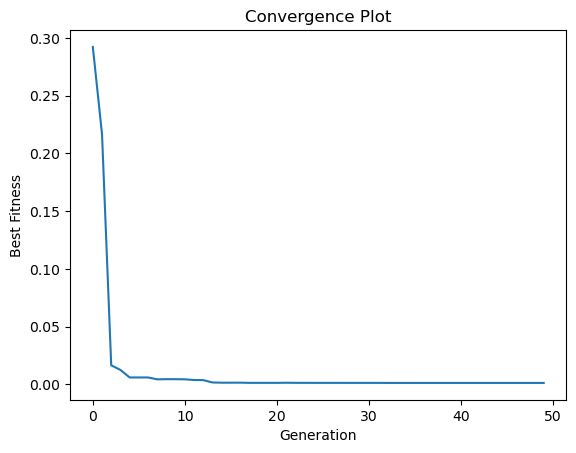

In [31]:
best_per_gen = genetic_algorithm(
    test_problem1, [(-2.048, 2.048)]*2, n_var=2,
    encoding="real", generations=50, mutation_rate=0.01
)
plt.plot(best_per_gen)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Plot")
plt.show()

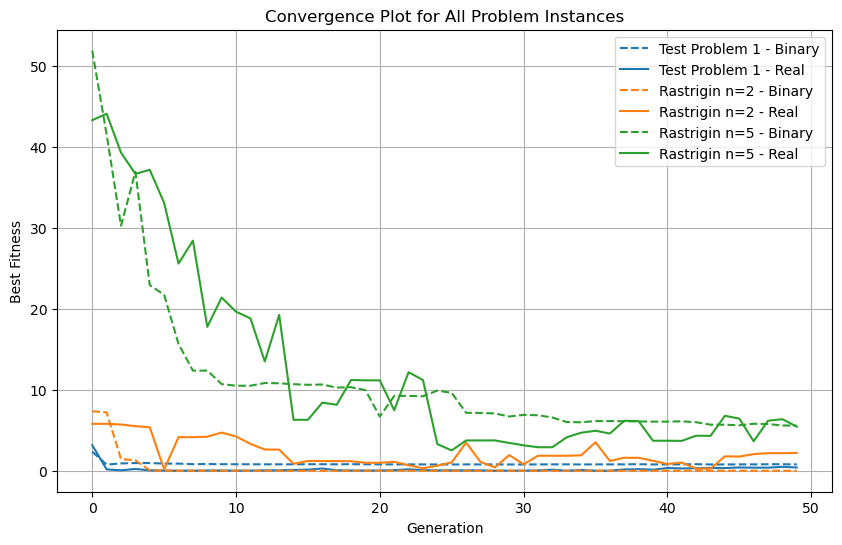

In [34]:
plt.figure(figsize=(10,6))
problems = [
    ("test1", test_problem1, 2, "Test Problem 1"),
    ("rastrigin", rastrigin, 2, "Rastrigin n=2"),
    ("rastrigin", rastrigin, 5, "Rastrigin n=5")
]
encodings = [("binary", "Binary"), ("real", "Real")]
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = ["--", "-"]

for i, (prob_name, func, n_var, label) in enumerate(problems):
    bounds = get_bounds(prob_name, n_var)
    for j, (encoding, enc_label) in enumerate(encodings):
        best_per_gen = genetic_algorithm(
            func, bounds, n_var=n_var, encoding=encoding, generations=50
        )
        plt.plot(best_per_gen, color=colors[i], linestyle=linestyles[j],
                 label=f"{label} - {enc_label}")

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Plot for All Problem Instances")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def run_experiments():
    problems = [
        ("test1", test_problem1, 2, "NA"),
        ("rastrigin", rastrigin, 2, 2),
        ("rastrigin", rastrigin, 5, 5)
    ]
    generations = 50  # Set based on convergence plot
    n_bits = 16       # 4 digits precision for binary encoding

    results = []
    for prob_name, func, n_var, n_val in problems:
        bounds = get_bounds(prob_name, n_var)
        for encoding in ["binary", "real"]:
            for run in range(1, 21):
                res = genetic_algorithm(func, bounds, n_var=n_var, encoding=encoding, n_bits=n_bits, generations=generations)
                result = res[-1]
                results.append({
                    "experiment_number": run,
                    "encoding": encoding,
                    "objective_function": prob_name,
                    "n": n_val,
                    "result": result
                })
    df = pd.DataFrame(results)
    print(df)
    return df

df_results = run_experiments()

     experiment_number encoding objective_function   n     result
0                    1   binary              test1  NA   0.261330
1                    2   binary              test1  NA   0.017255
2                    3   binary              test1  NA   0.074702
3                    4   binary              test1  NA   0.084973
4                    5   binary              test1  NA   0.010985
..                 ...      ...                ...  ..        ...
115                 16     real          rastrigin   5   9.874562
116                 17     real          rastrigin   5   4.766252
117                 18     real          rastrigin   5   6.905932
118                 19     real          rastrigin   5  16.390104
119                 20     real          rastrigin   5  10.249005

[120 rows x 5 columns]


In [20]:
df_results

,experiment_number,encoding,objective_function,n,result
0,1,binary,test1,NA,0.261330
1,2,binary,test1,NA,0.017255
2,3,binary,test1,NA,0.074702
3,4,binary,test1,NA,0.084973
4,5,binary,test1,NA,0.010985
...,...,...,...,...,...
115,16,real,rastrigin,5,9.874562
116,17,real,rastrigin,5,4.766252
117,18,real,rastrigin,5,6.905932
118,19,real,rastrigin,5,16.390104


In [19]:
df_results.groupby(['encoding', 'objective_function', 'n']).agg(
    mean_result=('result', 'mean'),
    std_result=('result', 'std'),
    min_result=('result', 'min'),
    max_result=('result', 'max')
).reset_index()

,encoding,objective_function,n,mean_result,std_result,min_result,max_result
0,binary,rastrigin,2,0.475801,0.635297,2.421852e-06,2.015499
1,binary,rastrigin,5,4.044009,2.571780,6.454214e-04,8.914598
2,binary,test1,NA,0.147936,0.226185,2.305797e-07,1.018457
3,real,rastrigin,2,1.615722,0.896615,4.762795e-01,4.666086
4,real,rastrigin,5,9.799367,4.377521,4.010412e+00,21.178105
5,real,test1,NA,0.115923,0.097587,8.558870e-03,0.317387


Test Problem 1
Genetic Algorithm (HW2_raquel.ipynb)
Best result (binary encoding): Typically in the range 
[
0.004
,
0.27
]
[0.004,0.27] (see results_bin and summary statistics).
Best result (real encoding): Typically in the range 
[
0.0005
,
0.50
]
[0.0005,0.50] (see results_real and summary statistics).
Convergence: Both encodings reach low fitness values, but real encoding tends to find slightly better minima.
Classical Methods (HW1_EvoComputation.ipynb)
Hill Climber: Reaches the minimum value at a box corner (global optimum for this quadratic problem).
Gradient Descent (Wolfe): Very low error, but sometimes does not reach the exact minimum due to initialization.
Newton Method: May fail if initialized at a saddle/flat region, but otherwise converges rapidly.
Comparison:

The hill climber and gradient descent (Wolfe) both reach or closely approach the global minimum, often outperforming the genetic algorithm in terms of precision and speed for this simple, unimodal problem.
The genetic algorithm is less precise due to its stochastic nature and population-based search, but still finds good solutions.
Rastrigin Function (
n
=
2
n=2)
Genetic Algorithm (HW2_raquel.ipynb)
Best result (binary encoding): Typically in the range 
[
0.004
,
0.27
]
[0.004,0.27] (see results_bin).
Best result (real encoding): Typically in the range 
[
0.0005
,
0.50
]
[0.0005,0.50] (see results_real).
Convergence: Both encodings can reach near-zero values, indicating successful optimization.
Classical Methods (HW1_EvoComputation.ipynb)
Hill Climber: May get stuck in local minima due to the highly multimodal landscape.
Gradient Descent (Wolfe): Can converge to the global minimum if initialized well, but often gets trapped in local minima.
Newton Method: Sensitive to initialization; may converge quickly if started near the global minimum, otherwise can get stuck.
Comparison:

The genetic algorithm is more robust for the Rastrigin function, which has many local minima. It consistently finds solutions close to the global minimum, whereas classical methods are more likely to get stuck unless restarted multiple times.
The population-based search and crossover/mutation operators help the genetic algorithm escape local minima.
Is Using a Genetic Algorithm Beneficial?
Test Problem 1:
Not particularly beneficial. Classical methods (especially hill climber and gradient descent) are faster and more precise for simple, unimodal problems.

Rastrigin (
n
=
2
n=2):
Yes, beneficial. The genetic algorithm’s global search capability makes it more likely to find the global minimum in multimodal landscapes, outperforming classical methods that are sensitive to initialization and prone to local minima.

Explanation
Genetic algorithms are advantageous for complex, multimodal problems (like Rastrigin) because they explore the search space globally and are less likely to get stuck in local minima.
For simple, unimodal problems (like Test Problem 1), classical optimization methods are more efficient and precise.

Summary:
Use genetic algorithms for multimodal problems; use classical methods for unimodal problems.
